# Score model

Use model to generate confusion matrix

<figure>
<img src="assets/score_matrix.png" width="400">
<figcaption align = "center"> Confusion matrix for validation data </figcaption>
</figure>


### Val data image map

The green dots within the red burn area represent false negatives -  we predicted the image at that location was not a fire (green) , but in reality it lies in the burn region (red)

<figure>
<img src="assets/plot_results_map.png" width="600">
<figcaption align = "center"> plot of validation data </figcaption>
</figure>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import intel_extension_for_pytorch as ipex
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
#from tqdm import tqdm
from PIL import Image
from data_loader import (
    TRAIN_DIR,
    VALID_DIR,
    augment_and_save,
    data_distribution,
    imagenet_stats,
    img_transforms,
    plot_data_distribution,
    show_data,
)
sns.set_theme(style="whitegrid", palette="husl")

2023-10-27 10:50:50,201 - numexpr.utils - INFO - Note: detected 224 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
2023-10-27 10:50:50,208 - numexpr.utils - INFO - Note: NumExpr detected 224 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-10-27 10:50:50,212 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


Device set to xpu by user.
OMP_NUM_THREADS set to: 112


# Define Predict Function

In [2]:
def predict(InFldr, ScoreDict, model):
    import torchvision.transforms as transforms
    import torch.nn as nn
    import glob 
    model.eval()

    scores = []
    fns = []
    transform = transforms.Compose([
        transforms.Resize((1024, 1024)),
        transforms.ToTensor(),
        transforms.Normalize(*imagenet_stats),
    ])
    
    for fn in glob.glob(TEST_DIR+'*.png'):
        img = Image.open(fn)
        img_tensor = transform(img).reshape(1, 3, 1024, 1024)
        score = 0
        modelCPU = model.to("cpu")
        score = np.argmax(torch.softmax( modelCPU(img_tensor).detach(), dim =1).numpy().squeeze())
        fns.append(fn)
        scores.append(ScoreDict[score])
    return (scores, fns)
# model.eval()
# with torch.no_grad():
#     model_scripted = torch.jit.script(model.to("cpu"))  # Export to TorchScript
#     model_scripted.save(model_save_path)  # Jit Save

In [3]:
import glob
import os
import os.path

def most_recent_model_created(requestedFile):
    path = 'models/'
    check_file = os.path.isfile(f'{path}/{requestedFile}')
    try: 
        if check_file:
            return latest_file
        else:
            list_of_files = glob.glob(f'{path}*_jit.pt') # * means all if need specific format then *.csv
            latest_file = max(list_of_files, key=os.path.getctime)
            return latest_file
    except:
        print("No models exist yet - can't score!")
    return ""

In [6]:
#model_save_path
requestedFile = "model_acc_86_device_xpu_lr_0.000214_epochs_6_jit.pt"
model_name =  most_recent_model_created(requestedFile)
print(model_name)
try:
    model_read = torch.jit.load(model_name)
except Exception as e:
    print(f"No models trained yet {e}")
#model_read.eval()

models/model_acc_94_device_xpu_lr_0.000214_epochs_6_jit.pt


# Scoring Individual Images with Model
### Known Fire

In [7]:
Fire_true = []
Fire_pred = []
Fire_pred_dict = {}
TEST_DIR =  'data/colorEnhanced/val/Fire/'
scoreDict = {0:'Fire', 1:'NoFire'}
scores, fns = predict(TEST_DIR, scoreDict, model_read)
for score, fn in zip(scores, fns):
    Fire_pred_dict[fn] = score
    print(f"{score}\t{fn}")
    if score == 'Fire': 
        Fire_pred.append(1)
    else:
        Fire_pred.append(0)
    Fire_true.append(1)

Fire	data/colorEnhanced/val/Fire/m_4012355_se_10_h_20160713_early_morning_with_a_wild_fire,_no_clouds_12.png
Fire	data/colorEnhanced/val/Fire/m_4012355_se_10_h_20160713_night_with_wild_fire_3.png
Fire	data/colorEnhanced/val/Fire/m_4012355_se_10_h_20160713_mid-day_signs_of_wild_fire_17.png
Fire	data/colorEnhanced/val/Fire/m_4012355_se_10_h_20160713_early_morning_with_a_wild_fire,_no_clouds_15.png
Fire	data/colorEnhanced/val/Fire/m_4012355_se_10_h_20160713_mid-day_2.png
Fire	data/colorEnhanced/val/Fire/m_4012355_se_10_h_20160713_early_morning_with_a_wild_fire,_no_clouds_6.png
Fire	data/colorEnhanced/val/Fire/m_4012355_se_10_h_20160713_late_afternoon_with_signs_of_wild_fire,_no_clouds_16.png
Fire	data/colorEnhanced/val/Fire/m_4012355_se_10_h_20160713_late_afternoon_with_signs_of_wild_fire,_no_clouds_19.png
Fire	data/colorEnhanced/val/Fire/m_4012355_se_10_h_20160713_early_morning_with_a_wild_fire,_no_clouds_18.png
Fire	data/colorEnhanced/val/Fire/m_4012355_se_10_h_20160713_mid-day_signs_of

# Scoring Individual Images with Model
### Known NoFire

# Define functions and normalization parameters

In [8]:
TEST_DIR =  'data/colorEnhanced/val/NoFire/'
scoreDict = {0:'Fire', 1:'NoFire'}
scores, fns = predict(TEST_DIR, scoreDict, model_read)
for score, fn in zip(scores, fns):
    Fire_pred_dict[fn] = score
    print(f"{score}\t{fn}")
    if score == 'Fire': 
        Fire_pred.append(1)
    else:
        Fire_pred.append(0)
    Fire_true.append(0)
len(Fire_pred)

NoFire	data/colorEnhanced/val/NoFire/m_4012241_se_10_h_20160712_early_morning_with_clear_skies_with_no_signs_of_wild_fire_5.png
NoFire	data/colorEnhanced/val/NoFire/m_4012241_se_10_h_20160712_no_signs_of_fire_1.png
NoFire	data/colorEnhanced/val/NoFire/m_4012241_se_10_h_20160712_mid-day_with_clear_skies_4.png
NoFire	data/colorEnhanced/val/NoFire/m_4012241_se_10_h_20160712_sparse_vegetation_no_signs_of_wild_fire_9.png
NoFire	data/colorEnhanced/val/NoFire/m_4012241_se_10_h_20160712_mid-day_with_clear_skies_with_no_signs_of_wild_fire_7.png
NoFire	data/colorEnhanced/val/NoFire/m_4012241_se_10_h_20160712_mid-day_with_clear_skies_with_no_signs_of_wild_fire_2.png
NoFire	data/colorEnhanced/val/NoFire/m_4012241_se_10_h_20160712_sparse_vegetation_no_signs_of_wild_fire_19.png
NoFire	data/colorEnhanced/val/NoFire/m_4012241_se_10_h_20160712_early_morning_with_clear_skies_with_no_signs_of_wild_fire_15.png
NoFire	data/colorEnhanced/val/NoFire/m_4012241_se_10_h_20160712_early_morning_with_clear_skies_w

50

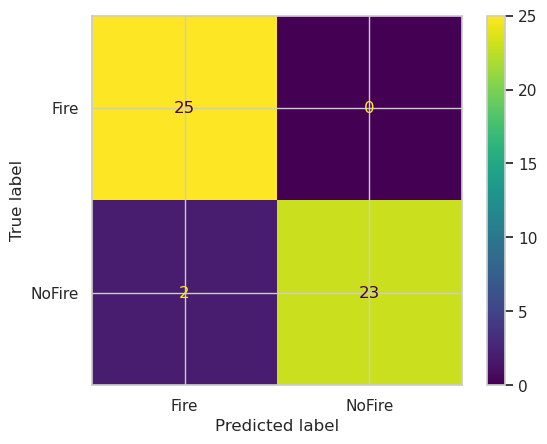

In [9]:
%matplotlib inline
fireDict = {0:'Fire', 1:'NoFire'}
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
YTRUE = [fireDict[val] for val in Fire_true]
YPRED = [fireDict[val] for val in Fire_pred]
labels=['Fire', 'NoFire']
cm = confusion_matrix(YTRUE, YPRED,  labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

plt.show()

In [10]:
import pandas as pd
import numpy as np

usgs = pd.read_csv('data/USGS_NAIP_Sampled_Mapping.csv')
usgs['Longitude'] = usgs['Centroid'].apply(lambda x: float(x.split('(')[-1].replace(')','').replace(' ','').split(',')[0]))
usgs['Lattitude'] = usgs['Centroid'].apply(lambda x: float(x.split('(')[-1].replace(')','').replace(' ','').split(',')[1]))

# ModisOutlineParadise = np.load('data/ModisOutlineParadise.npy')
# ModisOutlineNorth = np.load('data/ModisOutlineNorth.npy')
# ModisOutlineWest = np.load('data/ModisOutlineWest.npy' )

In [11]:
#Fire_pred_dict
colorEnhancedMap = pd.read_csv("data/ColorEnhanced_Mapping.csv")
colorEnhancedMap = colorEnhancedMap.drop(columns=['Unnamed: 0'])
colorEnhancedMap

,Long,Lat,Class,Name
0,-120.947196,40.004298,NoFire,m_3912045_ne_10_h_20160712_sparse_vegetation_n...
1,-120.628079,40.068760,NoFire,m_3912045_ne_10_h_20160712_early_morning_with_...
2,-123.394951,39.185473,NoFire,m_3912045_ne_10_h_20160712_dense_vegetation_wi...
3,-123.089519,40.527386,NoFire,m_3912045_ne_10_h_20160712_late_afternoon_with...
4,-120.278382,39.423949,NoFire,m_3912343_se_10_h_20160529_dense_vegetation_wi...
...,...,...,...,...
245,-121.833440,39.263026,Fire,m_4012355_se_10_h_20160713_early_morning_with_...
246,-121.593185,40.095536,Fire,m_4012355_se_10_h_20160713_late_afternoon_with...
247,-122.165480,39.737182,Fire,m_4012355_se_10_h_20160713_mid-day_signs_of_wi...
248,-122.227585,39.798355,Fire,m_4012355_se_10_h_20160713_late_afternoon_1.png


# Synthesize a Faux MODIS Burn Area

### Predicting Coordinates within and without the Polygon

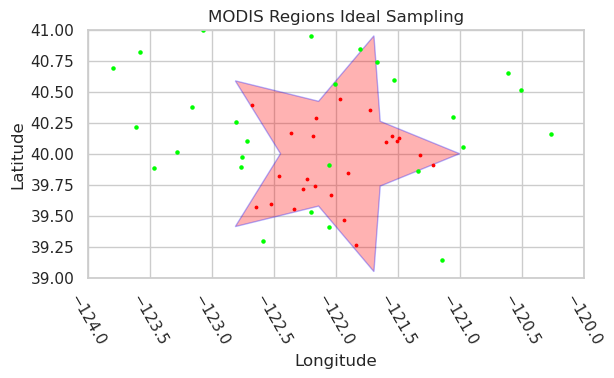

In [12]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from shapely.geometry import Polygon as GPoly
from shapely.geometry import Point
import random

fig, ax = plt.subplots()

N_rnd = 2000

xrnd = 4*np.random.sample(N_rnd) - 124
yrnd = 2*np.random.sample(N_rnd) + 39
prnd = np.array(list(zip(xrnd, yrnd)))

xmin = -124
xmax = -120

ymin = 39
ymax = 41

# Create star shape for synthetic MODIS
import numpy as np
pi = np.pi
x = []
y = []

for k in range(0,5):
    r = 4/9
    x.append( r*np.cos(2*pi*k/5 - 2*pi/10) - 122 )
    y.append( r*np.sin(2*pi*k/5 - 2*pi/10) + 40 )
    r = 1
    x.append(  r*np.cos(2*pi*k/5) - 122)
    y.append(  r*np.sin(2*pi*k/5) + 40)
    
polyStar =  np.array(list(zip(x,y))) 
polyStarP = Polygon(polyStar, closed=True,  fc=(1,0,0,0.3),  ec=(0,0,1,0.3))
polyStarG = GPoly(polyStar)

ax.add_patch(polyStarP)


# Color polyStar points red
test = []
for point in prnd:
    test.append(not polyStarG.contains(Point(point)))
test = np.array(test)
VertNoFire = np.array(list(zip(xrnd[test==True], yrnd[test==True])))

# Color polyStar points red
test = []
for point in prnd:
    test.append( polyStarG.contains(Point(point)))
test = np.array(test)
VertFire = np.array(list(zip(xrnd[test==True], yrnd[test==True])))

for fn, score in Fire_pred_dict.items():
    lat = colorEnhancedMap[colorEnhancedMap['Name'] == fn.split('/')[-1]]['Lat']
    long = colorEnhancedMap[colorEnhancedMap['Name'] == fn.split('/')[-1]]['Long']
    if score == 'Fire':
        plt.scatter(float(long),float(lat), s = 3, c='r')
    else:
        plt.scatter(float(long),float(lat), s = 5, c='lime')

# Set the aspect ratio and limits
plt.gca().set_aspect('equal')
plt.xlim(-124, -120)
plt.ylim(39.0, 41.0)
plt.xticks(rotation = -60)
# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('MODIS Regions Ideal Sampling')
plt.grid()
ax.grid()
# Show the plot
plt.show()    


## Notices and Disclaimers

Intel technologies may require enabled hardware, software or service activation.

No product or component can be absolutely secure. 

Your costs and results may vary. 

© Intel Corporation. Intel, the Intel logo, and other Intel marks are trademarks of Intel Corporation or its subsidiaries. Other names and brands may be claimed as the property of others. 